In [8]:
import torch.nn.functional as F
import torch
import sys

sys.path.append('/home/noam.koren/multiTS/NFT/')
from dicts import data_to_num_vars_dict
from models.NFT.NFT import NFT
from models.training_functions import read_all_data_and_print_stats, evaluate_model, save_model, plot_predictions, plot_specific_prediction, plot_poly, plot_fourier, save_predictions_in_excel

data = 'air_quality'

NUM_OF_VARS = data_to_num_vars_dict[data]
LOOKBACK = 40
HORIZON = 30

BATCH_SIZE = 32
NUM_EPOCHS = 30
PLOT_EPOCH = 100
blocks = 2
layers_type = 'tcn'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_to_save_model = f"/home/noam.koren/multiTS/NFT/models/NFT/trained_models/{data}/trained_models/model_{LOOKBACK}l_{HORIZON}h_{blocks}blocks_{layers_type}"
if data == 'ecg':
    n_people = 600
    n_rows = 700
    path_to_save_model += f"_{n_people}people_{n_rows}rows/"
else:
    path_to_save_model += '/'
path_to_save_checkpoint_models = path_to_save_model + "models_during_train/"
path_to_save_loss_plots = path_to_save_model + "loss_plots/"
path_to_save_prediction_plots = path_to_save_model + "prediction_plots/"


In [9]:
if data == 'ecg':
    data_path = f"/home/noam.koren/multiTS/NFT/data/{data}/{data}_{LOOKBACK}l_{HORIZON}h_{n_people}people_{n_rows}rows/"
else:
    data_path = f"/home/noam.koren/multiTS/NFT/data/{data}/{data}_{LOOKBACK}l_{HORIZON}h/"

train_X, train_y, val_X, val_y, test_X, test_y = read_all_data_and_print_stats(data_path=data_path, print_stats=True)


shape of:
train: X torch.Size([2785, 40, 13]), y: torch.Size([2785, 30, 13])
val: X torch.Size([1072, 40, 13]), y: torch.Size([1072, 30, 13])
test: X torch.Size([1643, 40, 13]), y: torch.Size([1643, 30, 13])

The highest value in train is: 4.197885036468506
The lowest value in the train is: -2.7500720024108887
The mean value in the train is: 1.3486569638843093e-09
The median value in the train is: -0.007876211777329445

The highest value in val is: 4.266589164733887
The lowest value in the val is: -3.970921516418457
The mean value in the val is: -0.060028936713933945
The median value in the val is: 0.0

The highest value in test is: 4.266589164733887
The lowest value in test train is: -4.385274887084961
The mean value in the test is: -0.3596659302711487
The median value in the test is: -0.2785773277282715


In [10]:
train_X, train_y, val_X, val_y, test_X, test_y = train_X.to(device), train_y.to(device), val_X.to(device), val_y.to(device), test_X.to(device), test_y.to(device)

| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=40, forecast_length=30, share_thetas=True) at @139953190206048
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=40, forecast_length=30, share_thetas=True) at @139953190216176
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=8, backcast_length=40, forecast_length=30, share_thetas=True) at @139953190207056
     | -- SeasonalityBlock(units=256, thetas_dim=8, backcast_length=40, forecast_length=30, share_thetas=True) at @139953188232832
Epoch 1, Average loss per data point: 1.0373626584424578
Epoch 01/30
88/88 [==============================] - 5s 57ms/step - loss: 1.0374 - val_loss: 1.4076
Epoch 2, Average loss per data point: 0.8076026285358134
Epoch 02/30
88/88 [==============================] - 4s 51ms/step - loss: 0.8076 - val_loss: 1.1792
Epoch 3, Average loss per data point: 0.7687026877

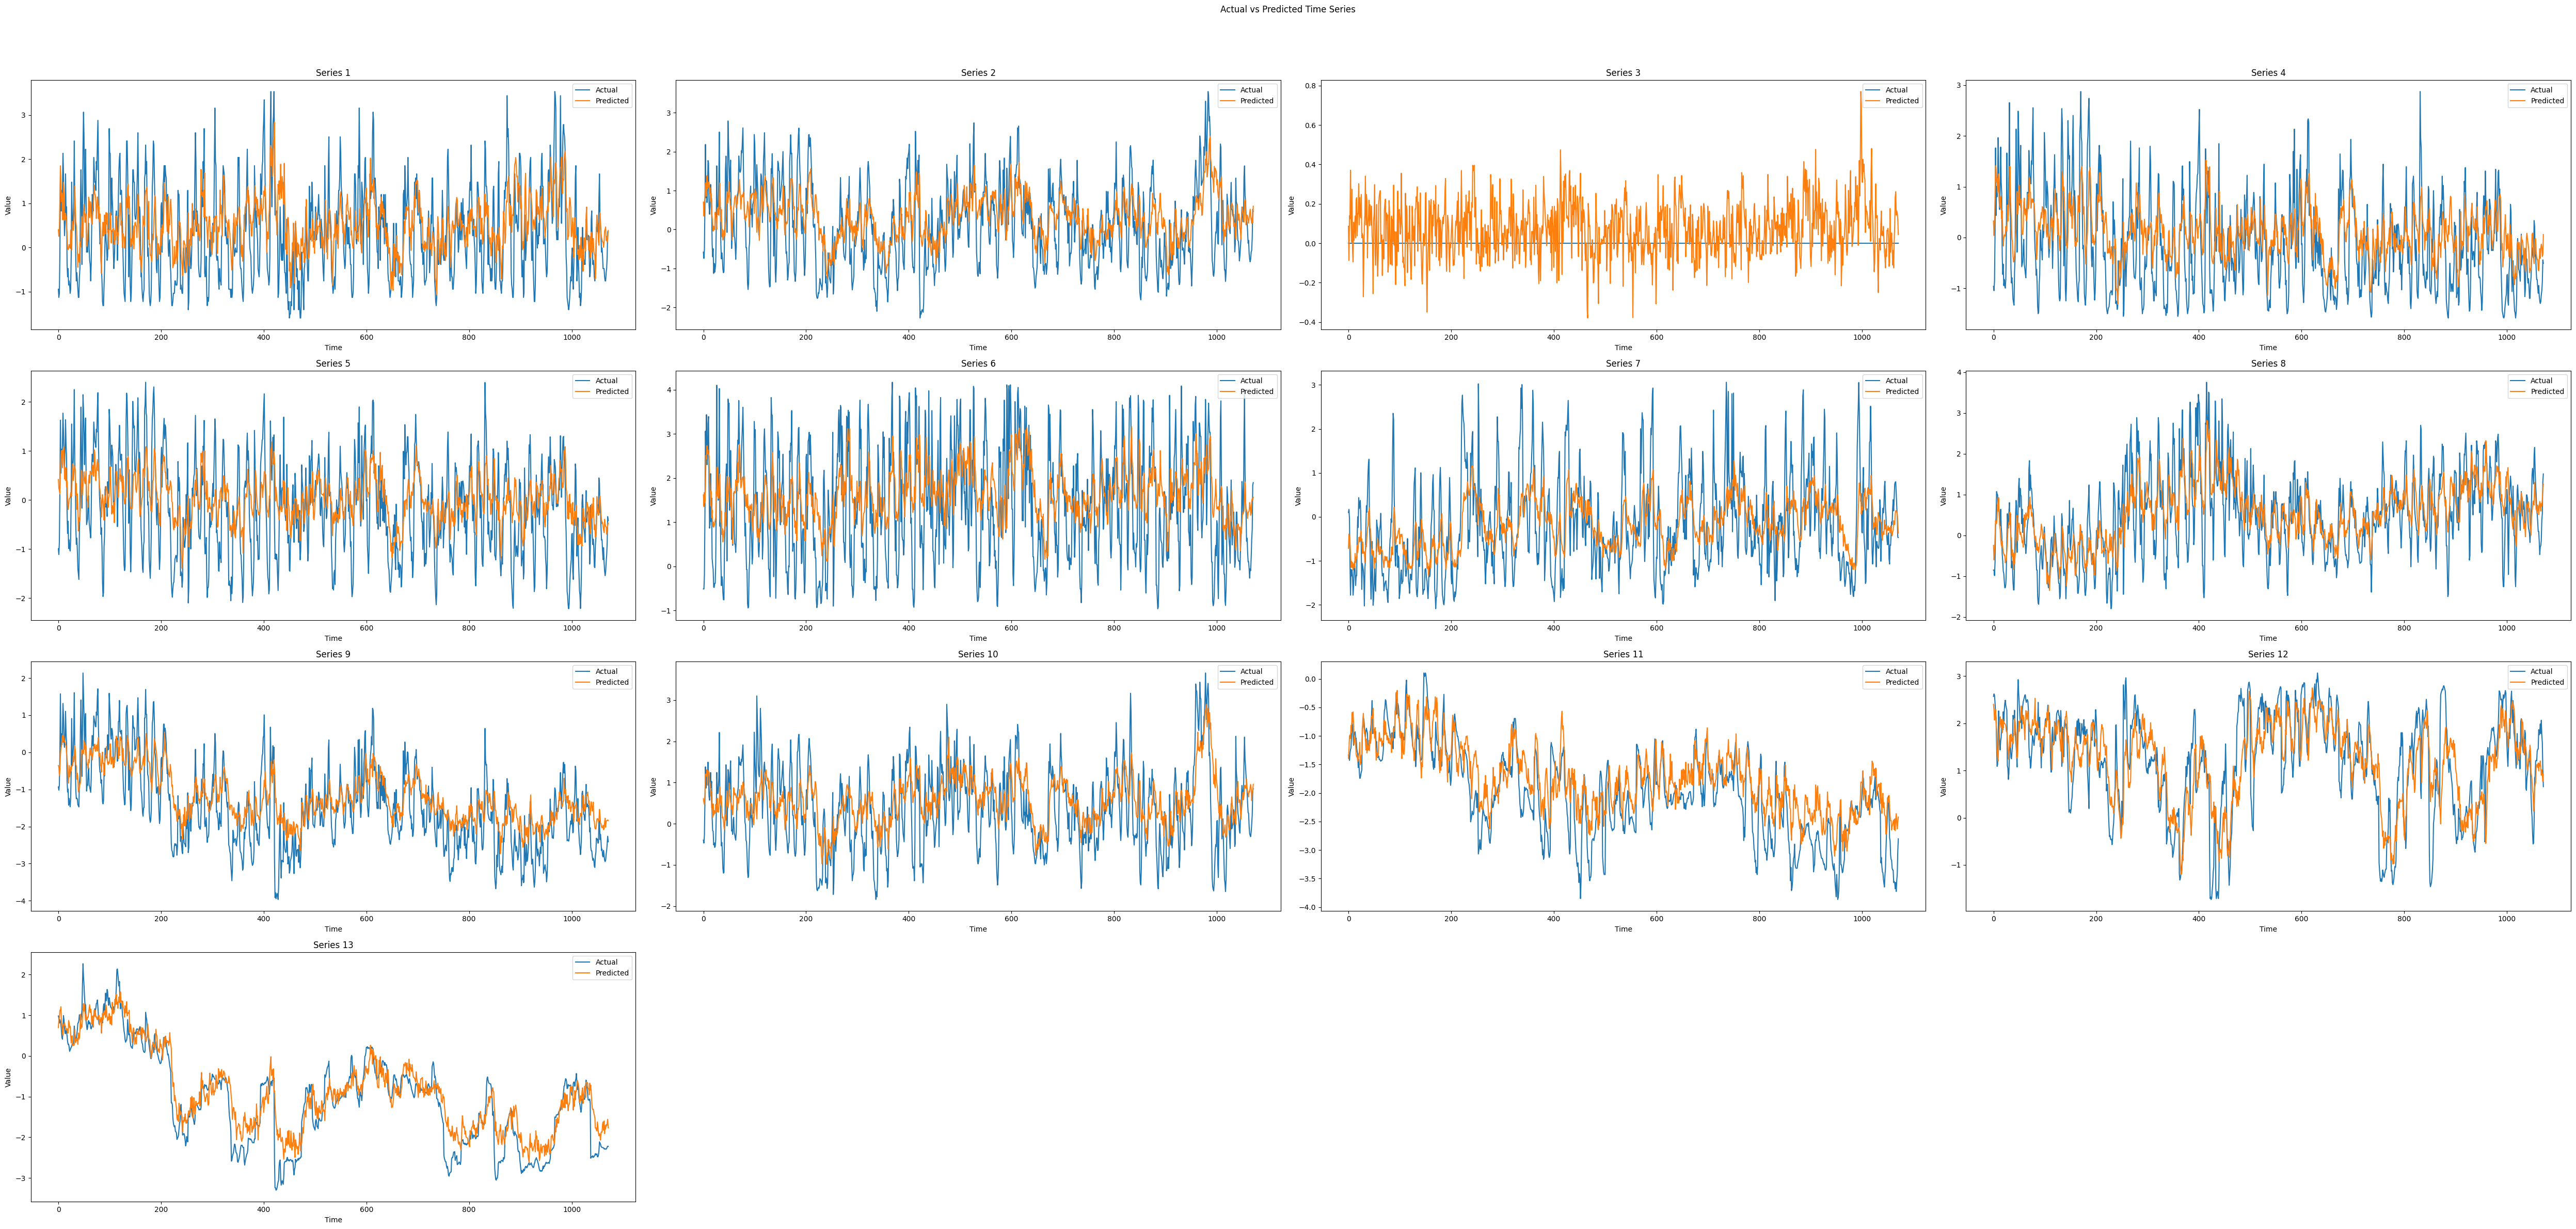

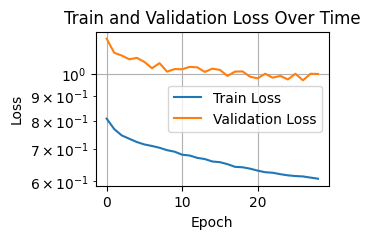

Saved model checkpoint at epoch 29 to /home/noam.koren/multiTS/NFT/models/NFT/trained_models/air_quality/trained_models/model_40l_30h_2blocks_tcn/models_during_train/model_checkpoint_epoch_29.pth
The min train loss is 0.6076541066490769 at epoch 29
The min val loss is 0.9684799909591675 at epoch 27



In [11]:
model = NFT(
    forecast_length=HORIZON,
    backcast_length=LOOKBACK,
    n_vars=NUM_OF_VARS,
    nb_blocks_per_stack=blocks,
    layers_type=layers_type,
    num_channels_for_tcn=[25, 50]
    ).to(device)

model.compile(loss='mse', optimizer='adam')

model.fit(
    x_train=train_X, 
    y_train=train_y, 
    validation_data=(val_X, val_y), 
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, 
    plot_epoch=PLOT_EPOCH,
    path_to_save_model=path_to_save_checkpoint_models,
    path_to_save_loss_plots=path_to_save_loss_plots,
    path_to_save_prediction_plots=path_to_save_prediction_plots
    )

# train_pred, val_pred, test_pred = evaluate_model(model, train_X, train_y, val_X, val_y, test_X, test_y)


In [12]:
# train_pred, train_trend, train_seasonality = model.predict(train_X, return_interpretable=True, return_thetas=True) 
# val_pred, val_trend, val_seasonality = model.predict(val_X, return_interpretable=True, return_thetas=True)
f, trend_forecast, seasonality_forecast, trend_thetas, seasonality_thetas = model.predict(test_X, return_interpretable=True, return_thetas=True)

x: torch.Size([1643, 40, 13]), trend_forecast: torch.Size([1643, 30, 13]), trend_thetas: torch.Size([1643, 13, 4])


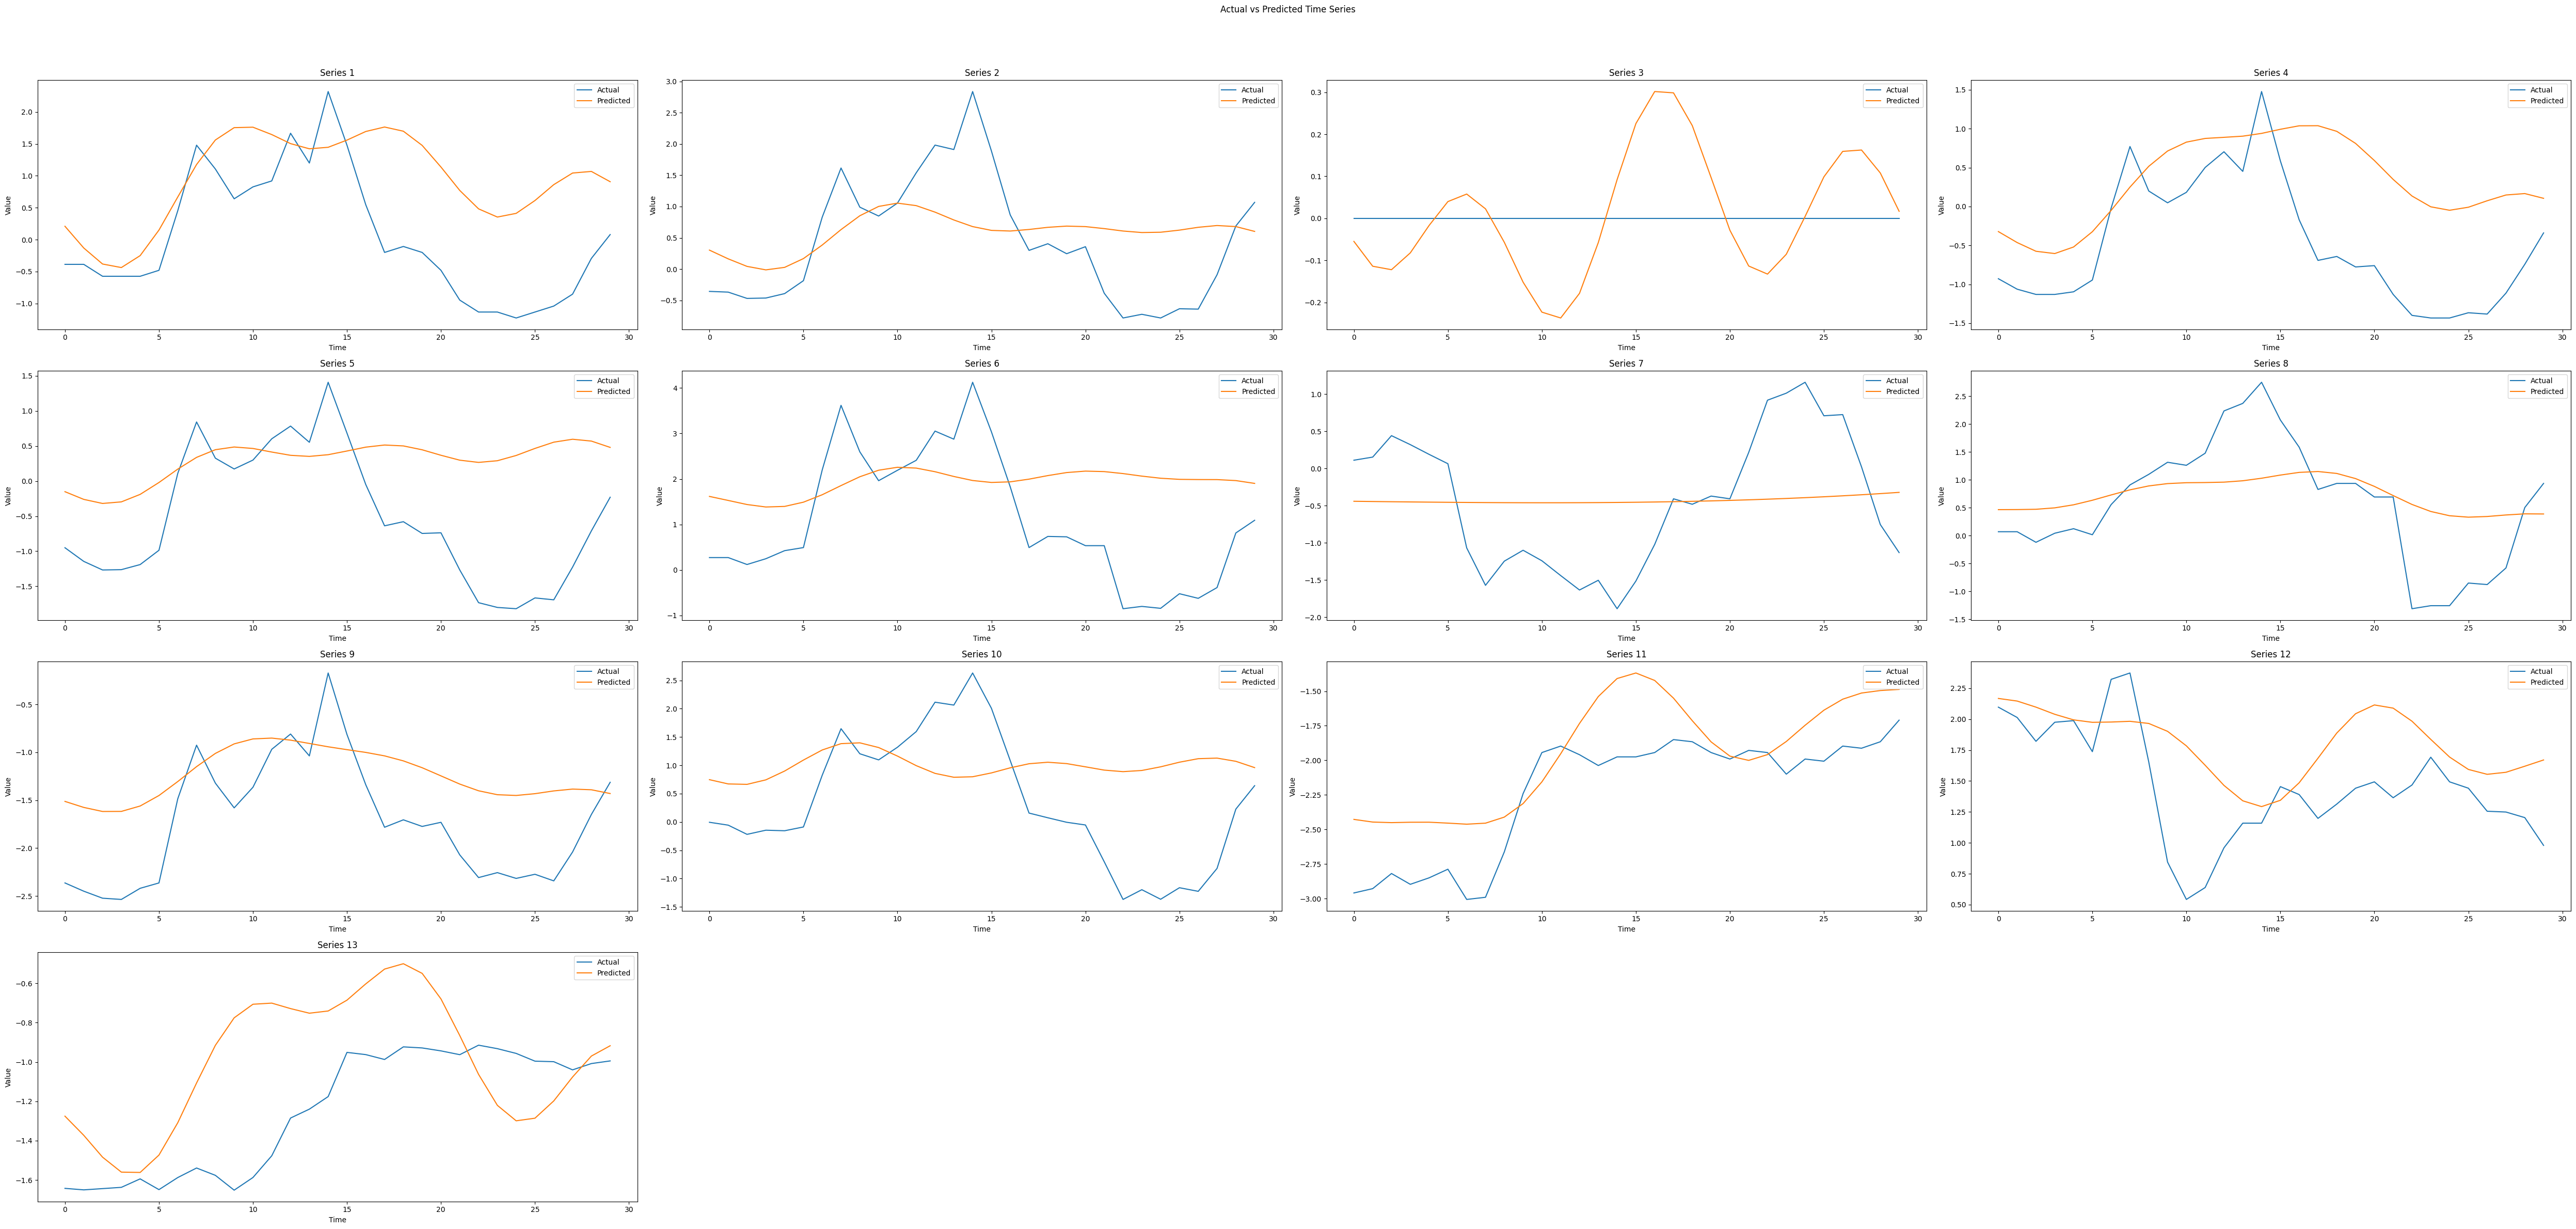

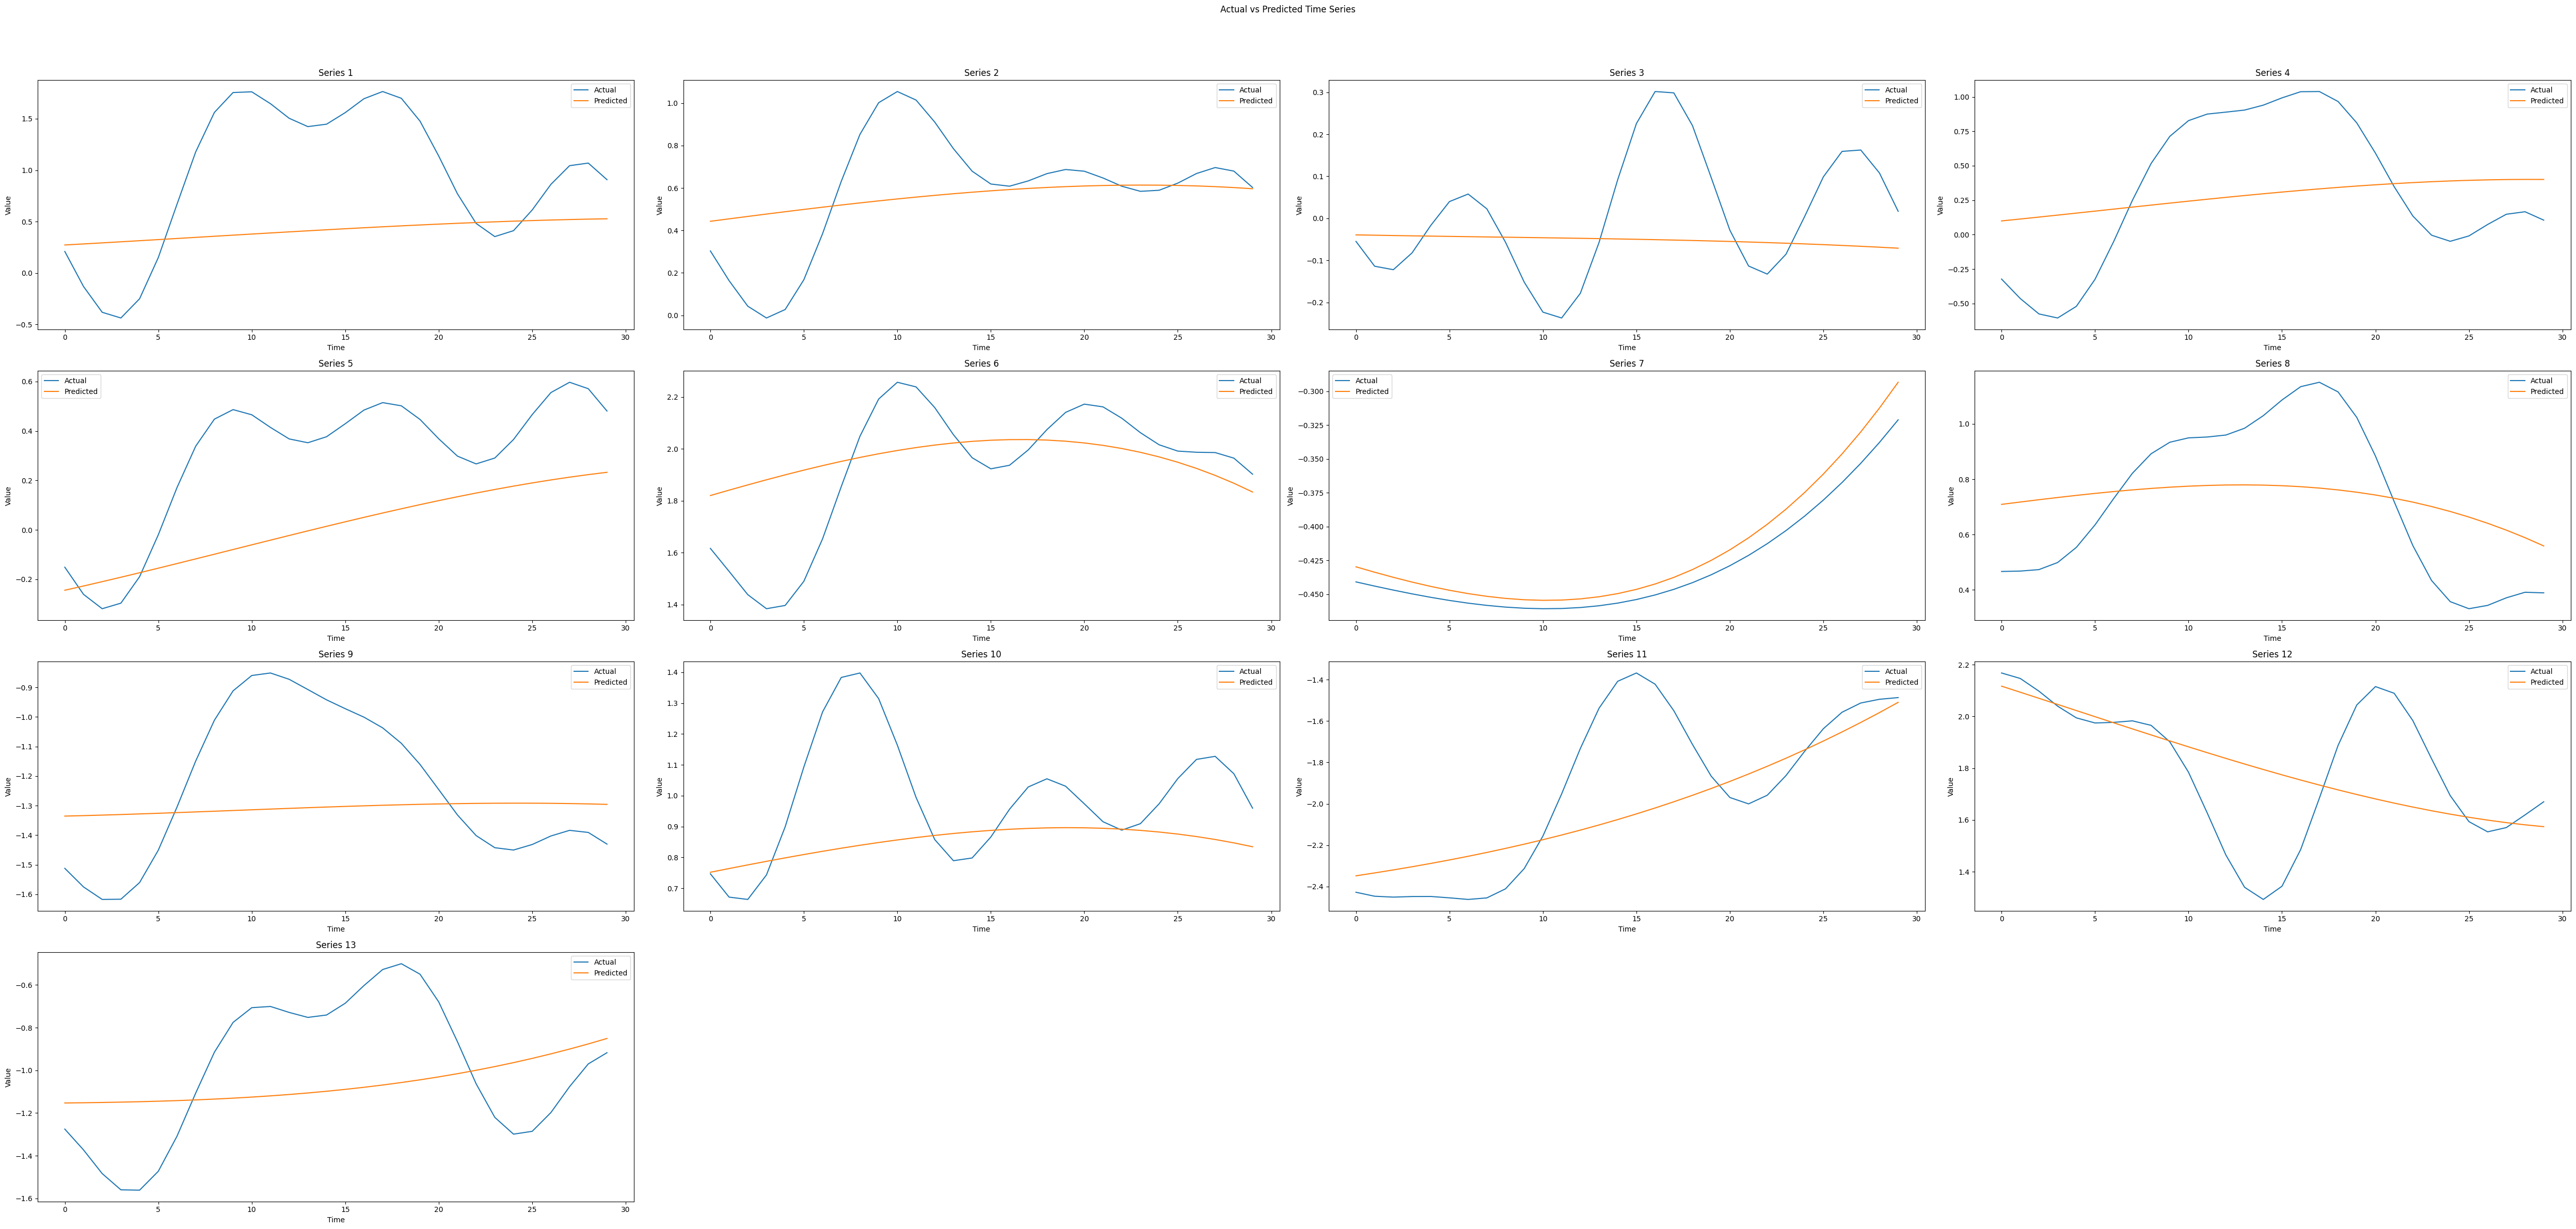

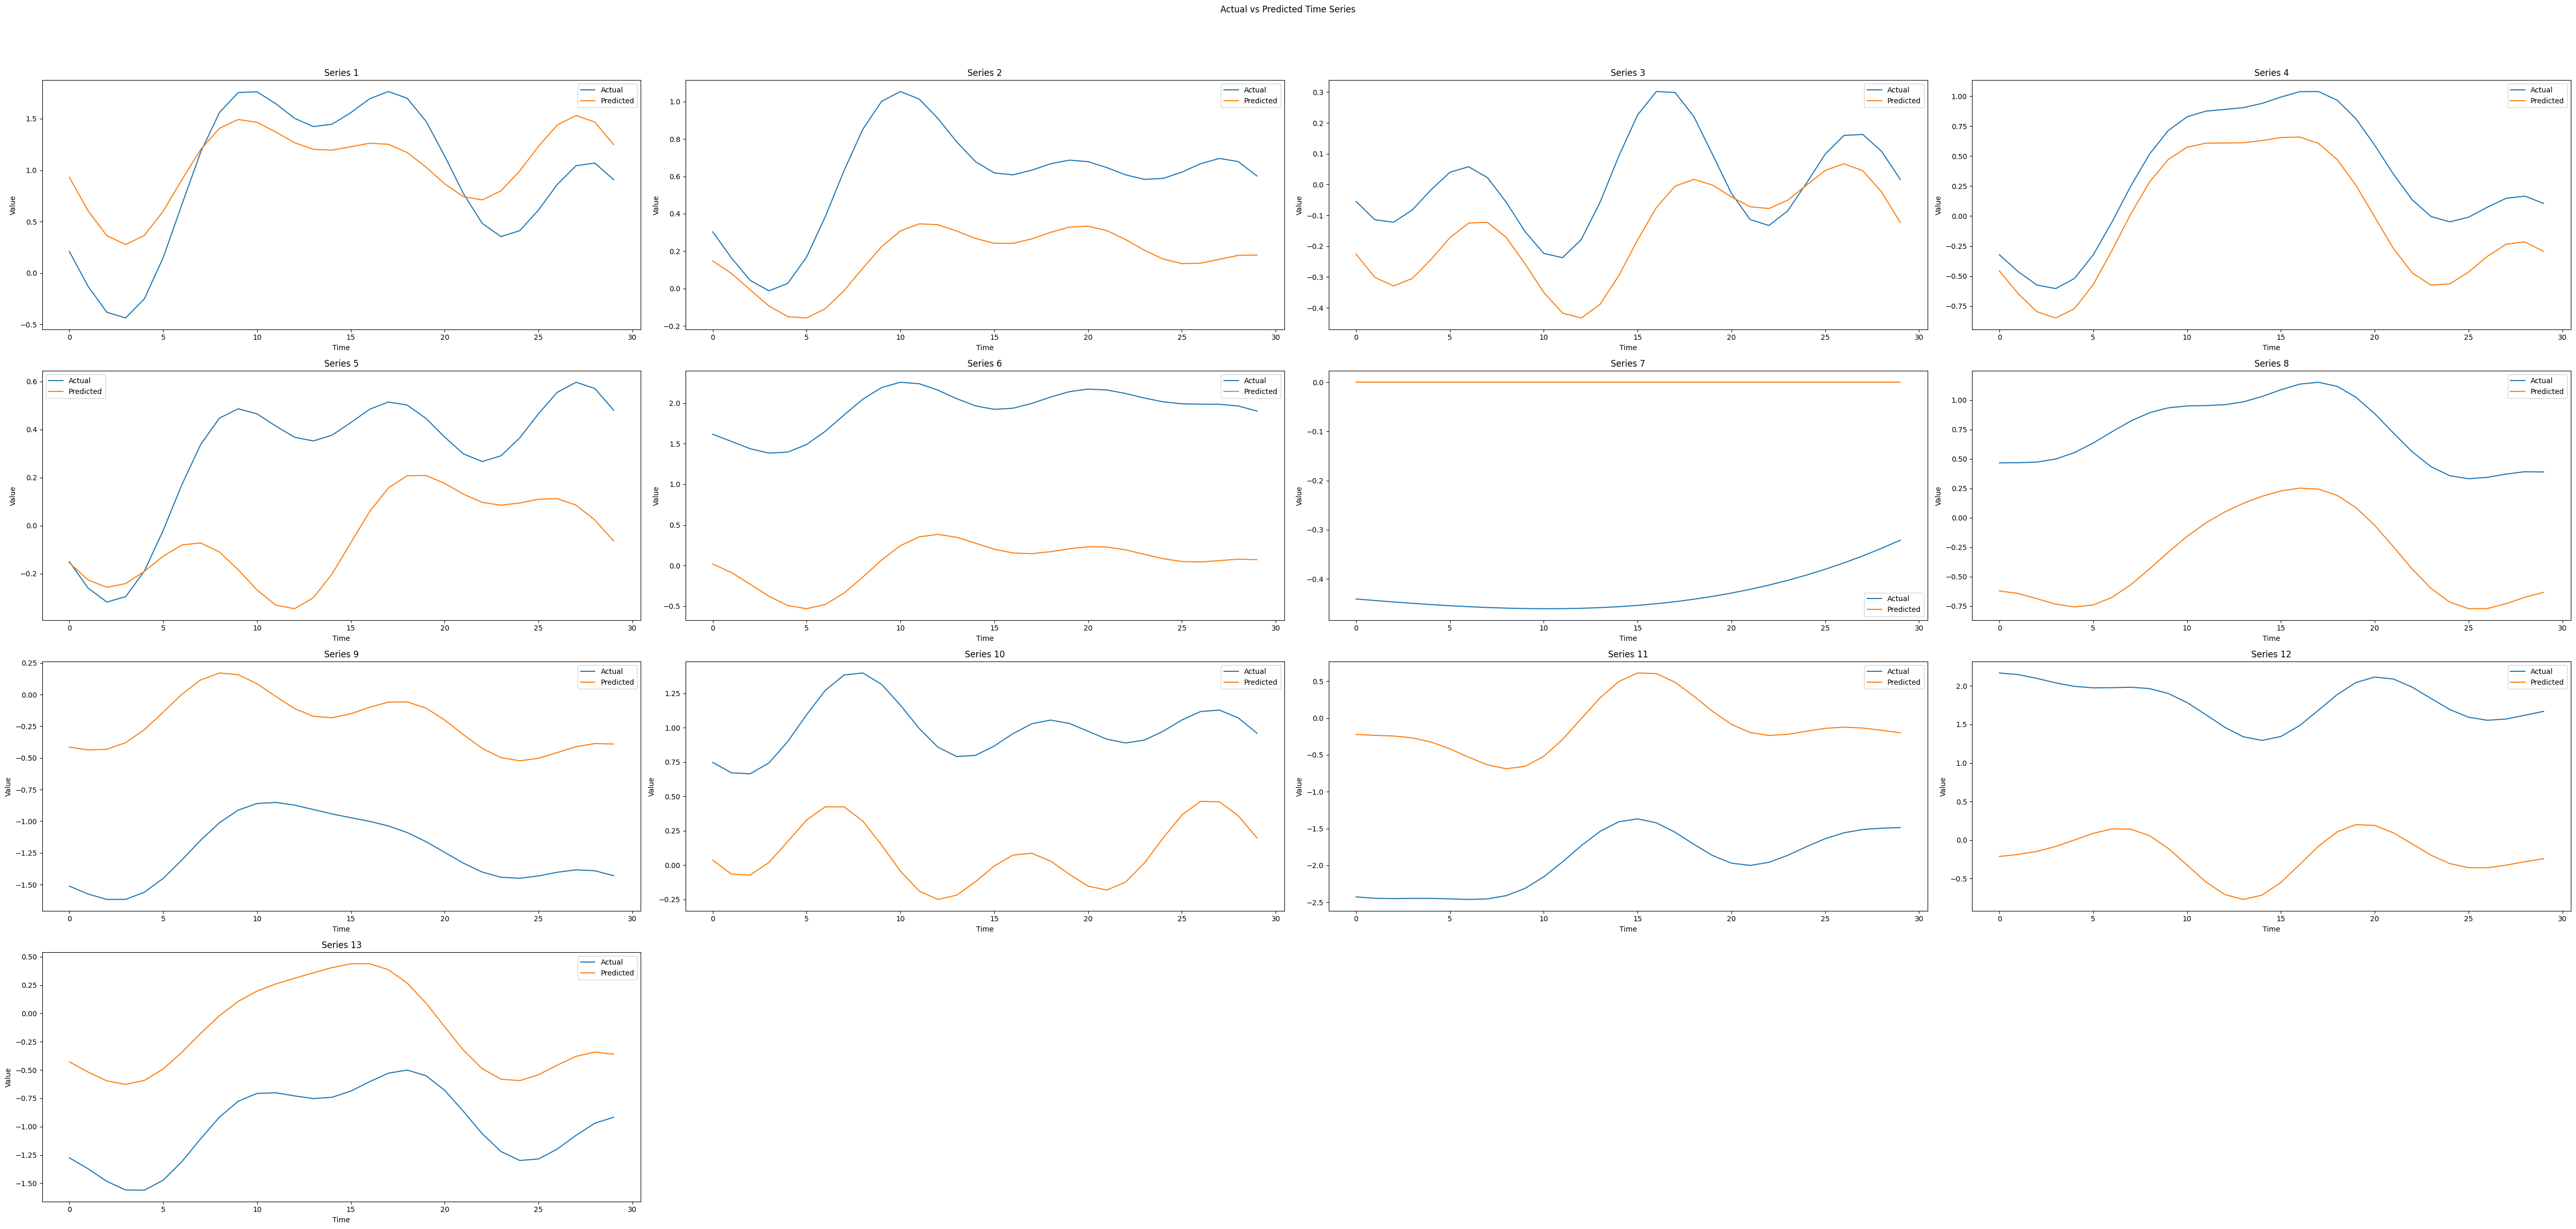

Actual Series 1  Predicted Series 1  Actual Series 2  Predicted Series 2  \
0          0.209859            0.930519         0.303412            0.147308   
1         -0.130266            0.603940         0.163516            0.080695   
2         -0.381181            0.363047         0.043178           -0.007666   
3         -0.436609            0.276945        -0.012438           -0.093823   
4         -0.249656            0.367061         0.027484           -0.150789   
5          0.150371            0.601694         0.167912           -0.157898   
6          0.668373            0.908704         0.384765           -0.108257   
7          1.177024            1.201337         0.631394           -0.011542   
8          1.560864            1.407568         0.852674            0.108948   
9          1.754559            1.492352         1.001873            0.223928   
10         1.761441            1.465106         1.054503            0.307724   
11         1.646040            1.370537         1.014458            0.346376   
12         1.504274            1.267183         0.910587            0.341377   
13         1.423316            1.202578         0.785254            0.307841   
14         1.446892            1.194882         0.679286            0.267938   
15         1.559335            1.227978         0.618796            0.242187   
16         1.694285            1.261519         0.608483            0.241899   
17         1.764199            1.251394         0.633368            0.265576   
18         1.698720            1.171902         0.667709            0.300450   
19         1.476483            1.030249         0.687150            0.328401   
20         1.137524            0.867046         0.679099            0.333780   
21         0.770997            0.742084         0.647237            0.309993   
22         0.482641            0.710638         0.608551            0.262246   
23         0.354413            0.799571         0.584361            0.205371   
24         0.412009            0.992893         0.589290            0.157654   
25         0.613180            1.233097         0.622951            0.133137   
26         0.861919            1.438658         0.668098            0.135531   
27         1.043710            1.531843         0.696358            0.156246   
28         1.068869            1.466877         0.679573            0.177451   
29         0.907682            1.248005         0.602386            0.179106   

    Actual Series 3  Predicted Series 3  Actual Series 4  Predicted Series 4  \
0         -0.054904           -0.225616        -0.322141           -0.456794   
1         -0.114030           -0.301264        -0.463158           -0.646656   
2         -0.122270           -0.328919        -0.575082           -0.797478   
3         -0.082253           -0.304527        -0.604515           -0.849738   
4         -0.016965           -0.242907        -0.520178           -0.771962   
5          0.039862           -0.172470        -0.323791           -0.570731   
6          0.057800           -0.124740        -0.049227           -0.287328   
7          0.022633           -0.122544         0.249499            0.017339   
8         -0.056996           -0.171302         0.516746            0.283650   
9         -0.151966           -0.256715         0.713318            0.472202   
10        -0.223323           -0.349738         0.827458            0.573910   
11        -0.237238           -0.417023         0.875004            0.608033   
12        -0.178551           -0.432954         0.889136            0.609589   
13        -0.057654           -0.388811         0.904133            0.611639   
14         0.092086           -0.295694         0.939764            0.629805   
15         0.225574           -0.180207         0.992554            0.655287   
16         0.301853           -0.074602         1.037357            0.659151   
17         0.298718           -0.005152         1.038544            0.606051   
18 

In [13]:
plot_specific_prediction(y=test_y, predictions=f, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS)
plot_specific_prediction(y=f, predictions=trend_forecast, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS)
plot_specific_prediction(y=f, predictions=seasonality_forecast, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS)

save_predictions_in_excel(y=f, predictions=trend_forecast, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS, 
                          path_to_save_prediction_excel='/home/noam.koren/multiTS/NFT/results/air_quality/nft/',
                          excel_name='trend_forecast')
save_predictions_in_excel(y=f, predictions=seasonality_forecast, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS, 
                          path_to_save_prediction_excel='/home/noam.koren/multiTS/NFT/results/air_quality/nft/',
                          excel_name='seasonality_forecast')


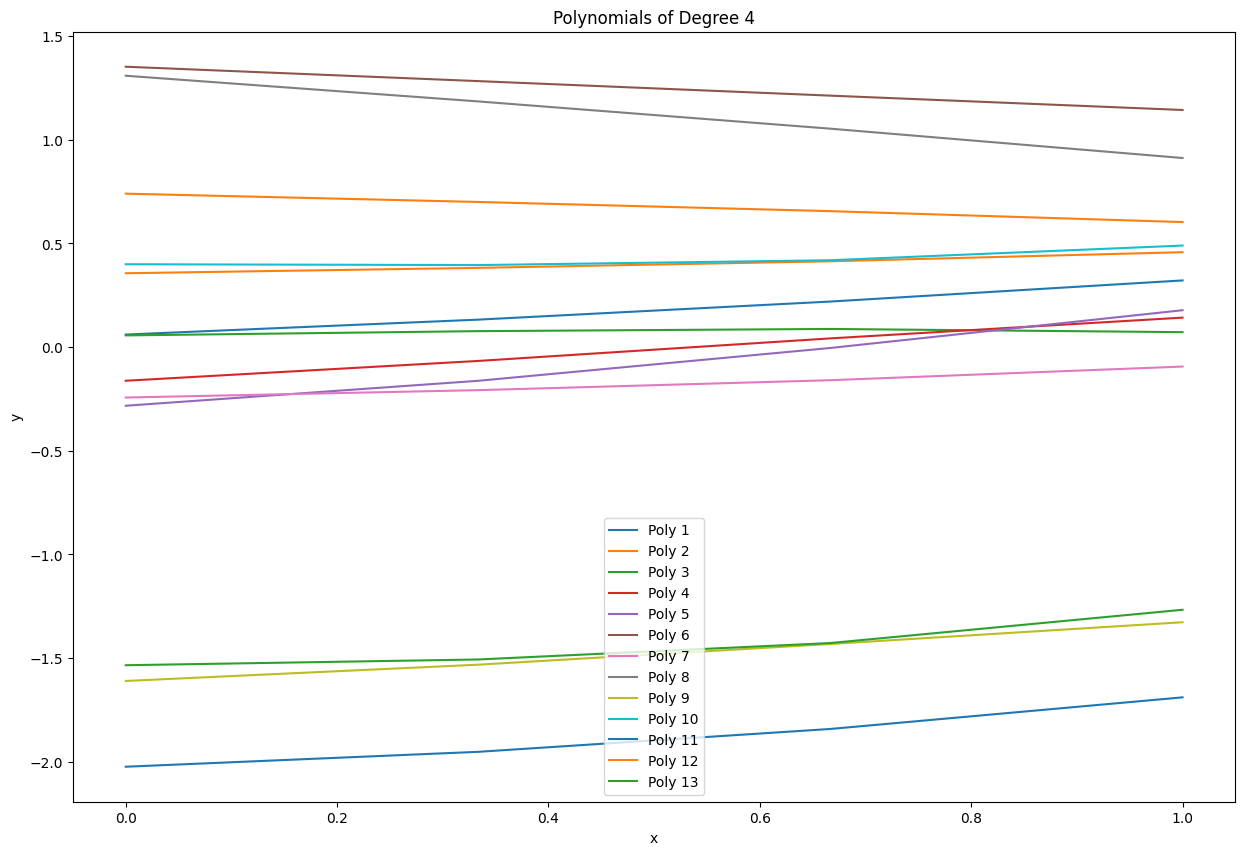

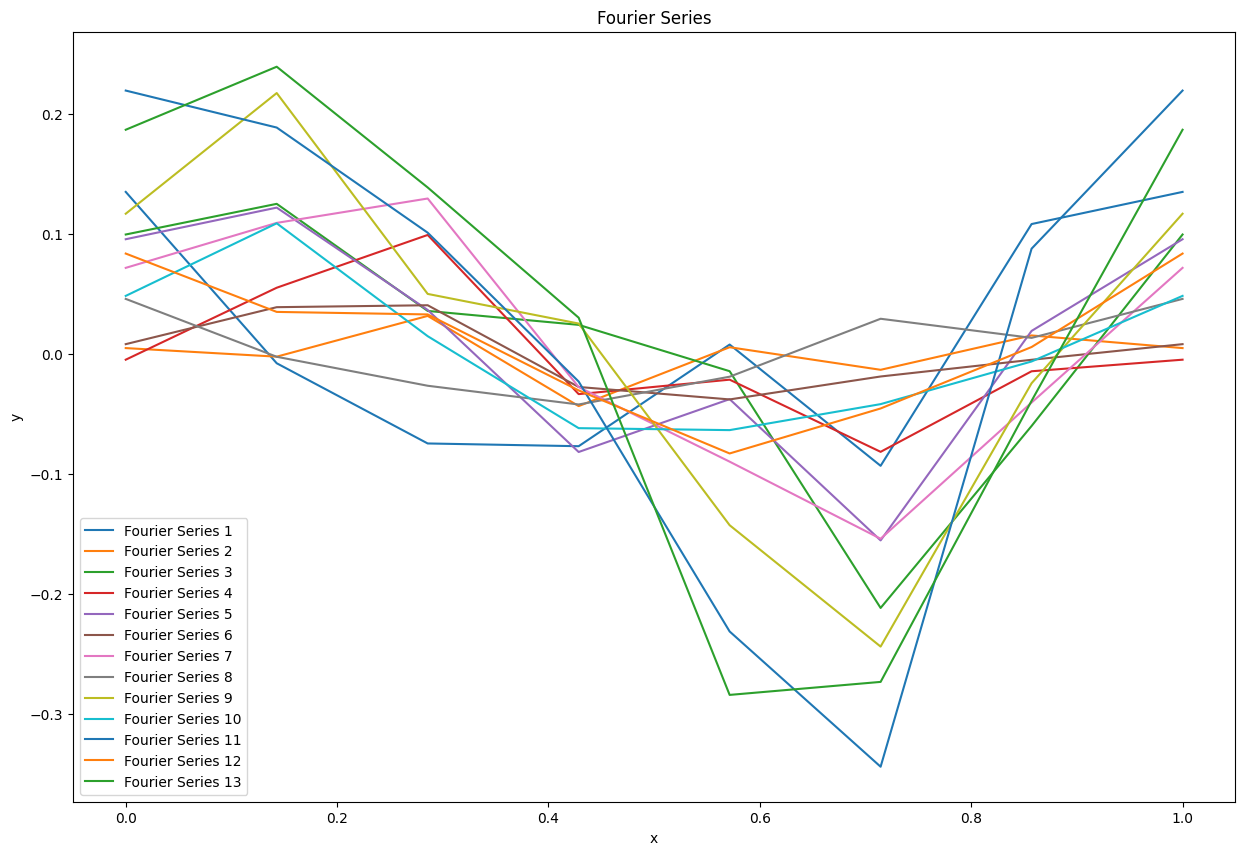

In [14]:
plot_poly(trend_thetas)
plot_fourier(seasonality_thetas)